In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [3]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\behno\AppData\Local\Temp\ipykernel_5916\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [5]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [6]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [8]:
inspector = inspect(engine)
measurement_columns = inspector.get_columns('measurement')

for column in measurement_columns:
    print(column)

{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'primary_key': 1}
{'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'primary_key': 0}


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
latest_date = pd.to_datetime(latest_date)

print(latest_date)

2017-08-23 00:00:00


In [10]:
# Retrieve the last 12 months of precipitation data
one_year_ago = latest_date - pd.DateOffset(days=365)
one_year_ago

Timestamp('2016-08-23 00:00:00')

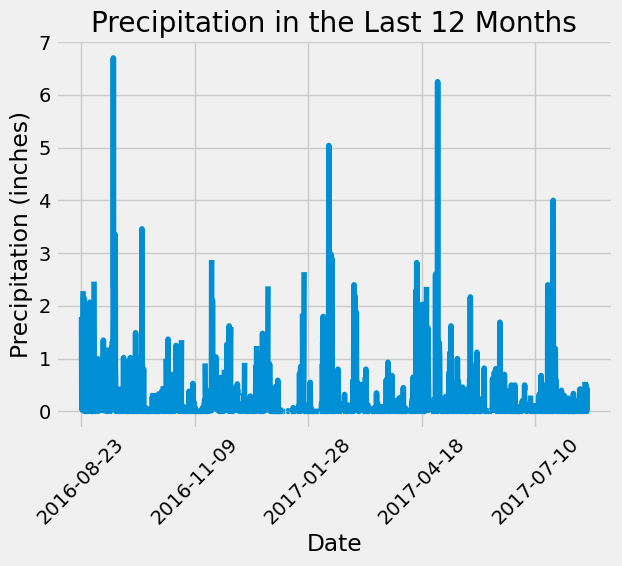

In [11]:
# Calculate the date one year ago from the latest date
one_year_ago_str = one_year_ago.strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago_str).all()

# Save the query results as a Pandas DataFrame with explicit column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the DataFrame by date
precipitation_df.sort_values(by='Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', rot=45, legend=False)
plt.title("Precipitation in the Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df.describe()
summary_statistics

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(total_stations)

9


In [14]:
# Design a query to find the most active stations
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Print the most active stations and their counts
print("Most-Active Stations:")
for station, count in most_active_stations:
    print(f"Station ID: {station}, Observations: {count}")


Most-Active Stations:
Station ID: USC00519281, Observations: 2772
Station ID: USC00519397, Observations: 2724
Station ID: USC00513117, Observations: 2709
Station ID: USC00519523, Observations: 2669
Station ID: USC00516128, Observations: 2612
Station ID: USC00514830, Observations: 2202
Station ID: USC00511918, Observations: 1979
Station ID: USC00517948, Observations: 1372
Station ID: USC00518838, Observations: 511


In [15]:
# Extract the most active station ID from the previous query
most_active_station_id = most_active_stations[0][0]

# Query to calculate lowest, highest, and average temperatures for the most active station
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station_id).all()

# Print the temperature statistics
print(f"Temperature Statistics for Station ID {most_active_station_id}:")
print(f"Lowest Temperature: {temperature_stats[0][0]}")
print(f"Highest Temperature: {temperature_stats[0][1]}")
print(f"Average Temperature: {temperature_stats[0][2]}")


Temperature Statistics for Station ID USC00519281:
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


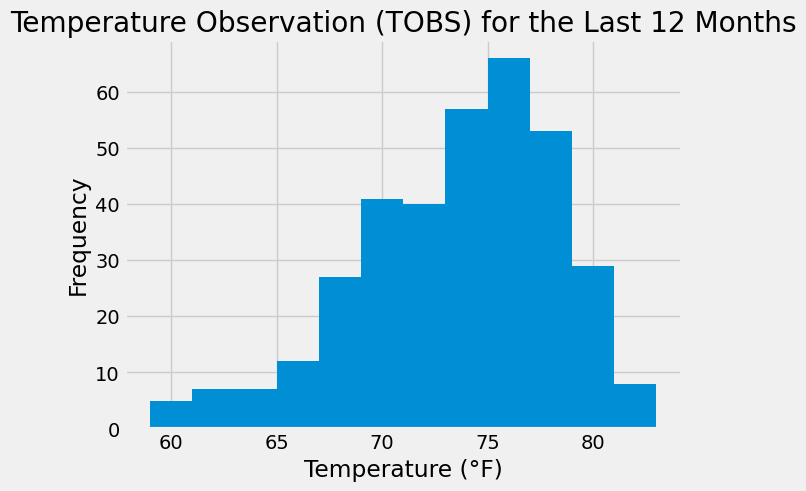

In [16]:
# Convert the date one year ago to a string
one_year_ago_str = one_year_ago.strftime("%Y-%m-%d")

# Design a query to get the last 12 months of TOBS data for the most active station
tobs_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago_str).all()

# Convert the query results to a Pandas DataFrame
tobs_df = pd.DataFrame(tobs_data, columns=['Date', 'Temperature'])

# Plot the results as a histogram with bins=12
tobs_df.plot(kind='hist', bins=12, legend=False)
plt.title("Temperature Observation (TOBS) for the Last 12 Months")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [17]:
# Close Session
session.close()